# LeNet - A convolutional neural network for the MNIST dataset

"LeNet" is a convolutional neural network for the MNIST dataset developed by Yann LeCun. It operates as follow:

1) Turn the 28x28 input images into 20 <i>feature maps</i> using 20 different convolutional kernels of size 5x5 (500 parameters plus 20 for the bias values) with ReLu activation function.

2)Use MaxPooling with a pool size of 2x2 and 2x2 stride to consolidate the information. The "2x2" stride moves a "2x2" window along both axes of the image without overlap, resulting in 20 14x14 feature maps.

3) Turn the 20 14x14 feature maps into 50 14x14 feature maps.

4) Use again maxpooling to create 20 7x7 feature maps.

5) Flatten all neurons into a single vector of 980 neurons and run them into a hidden layer of 500 neurons with ReLu activation. 

6) Adding a final hidden layer with 10 neurons and Softmax activation for 1,256,080 parameters total. 

This network is shown below
<center>
    <img src="figs/cnn.svg" width="75%">
</center>


In [30]:
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# From "Deeplearning with Keras"
NB_EPOCH = 5
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2
IMG_ROWS, IMG_COLS = 28, 28 # input image dimensions
NB_CLASSES = 10 # number of outputs = number of digits
INPUT_SHAPE = (1,IMG_ROWS, IMG_COLS)
# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
K.set_image_dim_ordering("th")
# consider them as float and normalize
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
y_test = np_utils.to_categorical(y_test, NB_CLASSES)

60000 train samples
10000 test samples


In [88]:
from keras.models import load_model

# initialize the optimizer and model
model = Sequential()
# CONV => RELU => POOL
model.add(Convolution2D(20, kernel_size=5, padding="same",input_shape=INPUT_SHAPE))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
# CONV => RELU => POOL
model.add(Convolution2D(50, kernel_size=5, padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Flatten => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
# a softmax classifier
model.add(Dense(NB_CLASSES))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])
model.summary()

#model = load_model('LeNet.h5')
#history = model.fit(X_train, y_train,batch_size=BATCH_SIZE, epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
score = model.evaluate(X_test, y_test, verbose=VERBOSE)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 20, 28, 28)        520       
_________________________________________________________________
activation_56 (Activation)   (None, 20, 28, 28)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 50, 14, 14)        25050     
_________________________________________________________________
activation_57 (Activation)   (None, 50, 14, 14)        0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 50, 7, 7)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 2450)              0         
__________

In [39]:
model.save('LeNet.h5')

[0.029565119414863374, 0.9905]


Test score: 0.036346319134981604
Test accuracy: 0.9873
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


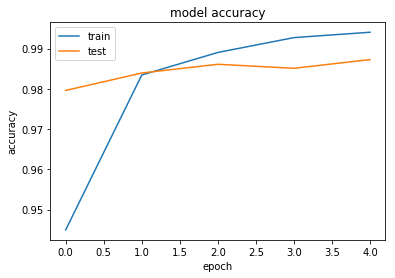

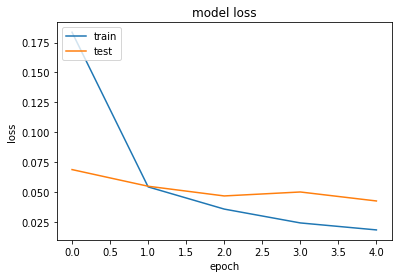

In [32]:
print("Test score:", score[0])
print('Test accuracy:', score[1])
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualizing individual layers

Now that we have a rough idea on what a convolution kernel would actually do to an image, it would be interesting to visualize the kernels that LeNet has actually found. The code below has been inspired from the article <a href="https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/">How to visualize filters and feature maps in convolutional neural networks</a>, and will show the kernels of the first convolutional layers as well as their application to the input image. 

In [82]:
from keras.models import load_model

model = load_model('LeNet.h5')

for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    print(layer.name, filters.shape)
    break # grabs only the first filter

conv2d_29 (5, 5, 1, 20)


## First Convolution

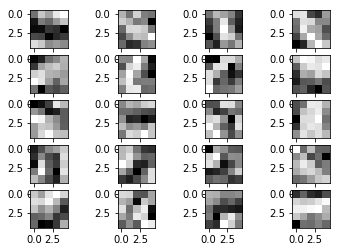

In [78]:
for I in range(5):
    for J in range(4):
        plt.subplot(5,4,I*4+J+1)
        plt.imshow(filters[:,:,0,I*4+J],cmap='gray')

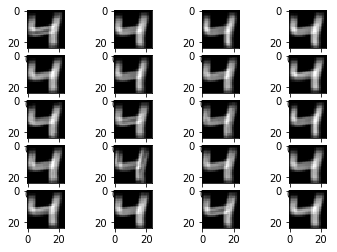

In [79]:
from scipy import signal

for I in range(5):
    for J in range(4):
        plt.subplot(5,4,I*4+J+1)
        plt.imshow(signal.convolve2d(X_train[2,0,:,:],filters[:,:,0,I*4+J],mode='valid'),cmap='gray')

## First MaxPooling



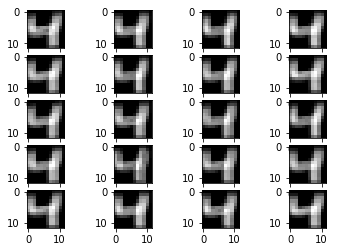

In [80]:
import skimage.measure

for I in range(5):
    for J in range(4):
        plt.subplot(5,4,I*4+J+1)
        plt.imshow(skimage.measure.block_reduce(signal.convolve2d(X_train[2,0,:,:],filters[:,:,0,I*4+J],mode='valid'), (2,2), np.max),cmap='gray')


## Second Convolution

Inspecting the second convolutional layer with 50 feature maps, we find 20x50 5x5 kernels as each feature map is a weighted sum of all previous 20 feature maps. We will instead build an intermediate model that ends at the fifth layer and visualize the 50 feature maps directly. 

In [119]:
from keras.models import Model

intermediate_layer_model = Model(inputs=model.input,outputs=model.layers[4].output)
intermediate_output = intermediate_layer_model.predict(np.expand_dims( X_train[2,:,:,:], axis=0))


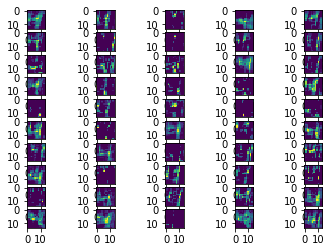

In [125]:
for I in range(10):
    for J in range(5):
        plt.subplot(10,5,I*5+J+1)
        plt.imshow(intermediate_output[0,I*5+J,:,:])